# [NEW] 고양이 수염 스티커 만들기  

openCV와 dlib을 활용하여 얼굴인식 -> 고양이 수염 스티커를 붙여보자!

In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 1. 이미지 불러오기

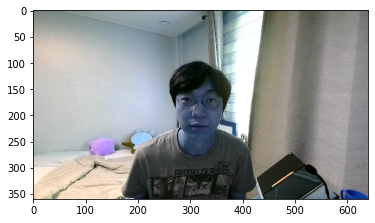

In [19]:
my_image_path = "./camera_sticker/images/image.png"
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640,360))
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

사진을 불러오니 푸른 빛이 감도는 사진이 나와버린다...   
그 이유는, 보통 matplotlib, dlib 등의 이미지 라이브러리는 이미지 라이브러리의 이미지 채널은 **RGB**순서로 사용하지만, openCV는 예외적으로 **BGR**순으로 사용한다.   
때문에 matplotlib으로 출력할 땐 색상을 보정할 필요가 있다!

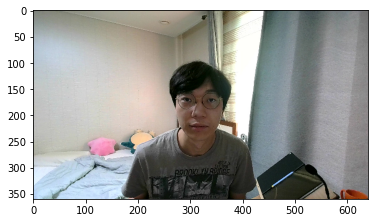

In [20]:
# plt.imshow 이전에 RGB 이미지로 바꾸자!
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. Face detection / landmarks

dlib의 `face detector`는 HOG(Histogram of Oriented Gradients) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는다. [참고 링크](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)

이미지에서 그래디언트(gradient)를 특징(feature)으로 사용하는 이유는, 픽셀들의 RGB값들 자체를 보는 것이 아니라, 인접한 픽셀들의 변화율을 통해 특징을 제대로 반영하는 편이다. 이미지의 맥락을 파악하는 것! 오브젝트라도 밝을 때와 어두울 때의 픽셀값의 분포는 완전히 다르지만, 밝기가 변하는 방향(그래디언트)만 고려하면 주변 상황과 무관하게 동일한 표현(representation)을 얻을 수 있다   
[이미지 피라미드란?](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

rectangles[[(259, 140) (366, 247)]]


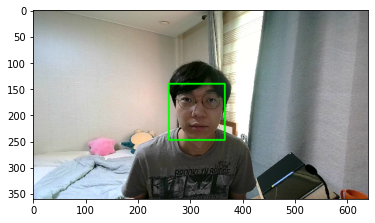

In [21]:
import dlib
detector_hog = dlib.get_frontal_face_detector() # detector 선언

# 얼굴의 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)
print(dlib_rects)

# bounding box에서 상하좌우 좌표를 확인
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 좌표대로 이미지에 사각형을 그린다
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2,
                  lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

bounding box로 crop된 얼굴을 기준으로 `object keypoint estimation`을 통해 keypoint를 찾습니다.
1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성   
1번 방법을 통해 가보자   
   
Dlib landmark localization을 통해 이목구비를 찾는다. 이번엔 ibug 300w 데이터셋 모델을 통해 68개의 점을 찾아낸다.

In [29]:
# ibug 300w 데이터셋을 통한 landmark 모델 불러오기
# wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

model_path = "../../data/shape_predictor_68_face_landmarks.dat"
landmark_predictor = dlib.shape_predictor(model_path)

landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환한다.

In [30]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


`points`는 `dlib.full_object_detection` 의 객체이기 때문에 `parts()` 함수로 개별 위치에 접근 가능하다. `list_points`라는 변수에 튜플 (x, y)에 반복하며 넣어 68개의 점을 저장한다. `list_landmarks`에는 얼굴 갯수만큼 또 저장이 된다!

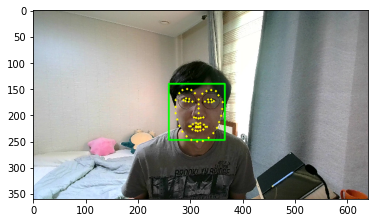

In [23]:
# 출력해보자!
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0,255,255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 스티커 적용하기

In [14]:
#좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.height()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(316, 196)
(x,y) : (316,196)
(w,h) : (108,108)


코 중심 좌표는 (316, 196), 이후는 bounding box의 영역을 출력한다. (108 X 108)

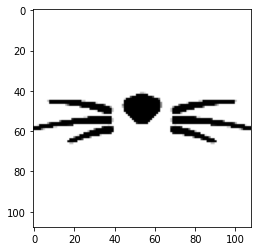

(108, 108, 3)


In [16]:
# 스티커를 불러오자
sticker_path = './cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)
plt.show()
print (img_sticker.shape)

이미지 시작점은 top-left 좌표이기 때문에, 그에 맞춰 스티커를 원본 이미지에 맞춰 이동시키자.

In [26]:
refined_x = int(x - w//2.05)       # left
refined_y = int(y - w//2.1)       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (264,145)


고양이 수염 이미지가 부착될 top-left 지점은 (264,145) 좌표로 설정   
여기서부터, top-left ~ left-down / top-left ~ top-right 영역만큼 `sticker_area`로 설정한다.   
`np.where`를 통해 `img_sticker`가 `0`인 영역(하얀색-0)은 `sticker_area`로 적용, `0`이 아닌 곳(검은색-255)은 `img_sticker`를 적용시킨다.

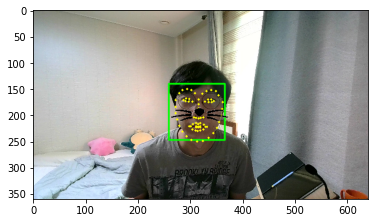

In [27]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이젠 bounding box와 landmark를 생략한 채 사진을 출력

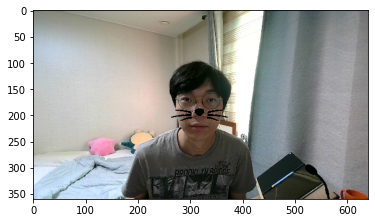

In [28]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area, img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 더 나아가기
위에서는 정면으로 찍었을 뿐, 이번엔 다른 각도로도 시도해보자!   
앞선 코드들을 활용하여 다시 적용

### 다른 각도의 스티커 붙이기 (test1)

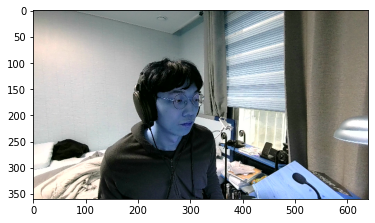

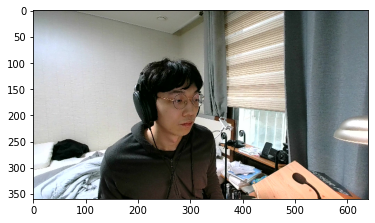

rectangles[[(245, 146) (335, 236)]]


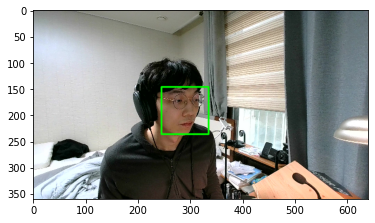

68
(305, 198)
(x,y) : (305,198)
(w,h) : (91,91)
(x,y) : (261,155)


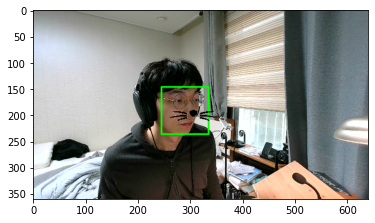

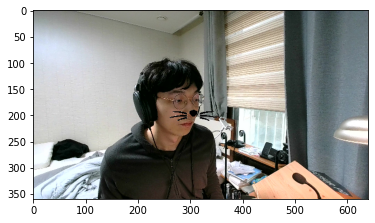

In [36]:
my_image_path = "./camera_sticker/images/image2.png"
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640,360))
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

# plt.imshow 이전에 RGB 이미지로 바꾸자!
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

import dlib
detector_hog = dlib.get_frontal_face_detector() # detector 선언

# 얼굴의 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)
print(dlib_rects)

# bounding box에서 상하좌우 좌표를 확인
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 좌표대로 이미지에 사각형을 그린다
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2,
                  lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# ibug 300w 데이터셋을 통한 landmark 모델 불러오기
# wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

model_path = "../../data/shape_predictor_68_face_landmarks.dat"
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

#좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.height()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

# 스티커를 불러오자
sticker_path = './cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

refined_x = int(x - w//2.05)       # left
refined_y = int(y - w//2.1)       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area, img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

얼굴이 조금 틀어져 있음에도 불구하고, 수염은 그대로 정면을 바라본 그대로 나와버린다... 수염도 얼굴 각도에 따라 틀어질 필요가 있다   

## 4.1 스티커를 틀어보자!
-> `cv2.getPerspectiveTransform()`를 통해 변환행렬을 구하고, `cv2.warpPerspective()`를 통해 적용시켜 스티커를 변환해보자!

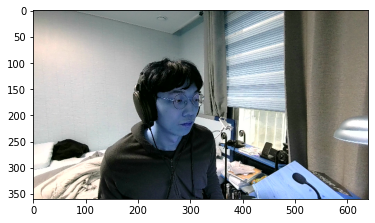

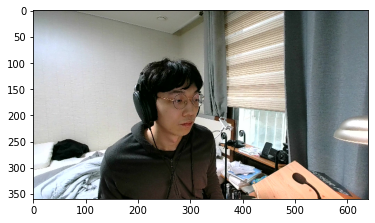

rectangles[[(245, 146) (335, 236)]]


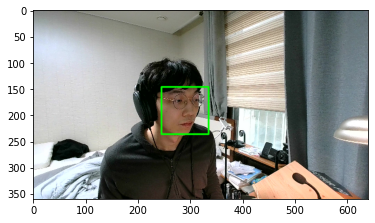

[[251. 162.]
 [252. 228.]
 [325. 162.]
 [303. 221.]]


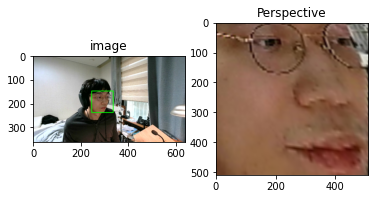

In [49]:
my_image_path = "./camera_sticker/images/image2.png"
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640,360))
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

# plt.imshow 이전에 RGB 이미지로 바꾸자!
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

import dlib
detector_hog = dlib.get_frontal_face_detector() # detector 선언

# 얼굴의 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)
print(dlib_rects)

# bounding box에서 상하좌우 좌표를 확인
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 좌표대로 이미지에 사각형을 그린다
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2,
                  lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# ibug 300w 데이터셋을 통한 landmark 모델 불러오기
# wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

model_path = "../../data/shape_predictor_68_face_landmarks.dat"
landmark_predictor = dlib.shape_predictor(model_path)

# 얼굴의 랜드마크 지점 중, 17, 5, 26, 11을 사용한다.

# [x,y] 좌표점을 4x2의 행렬로 작성
# 좌표점은 좌상->좌하->우상->우하
for landmark in (list_landmarks):
    pts1 = np.float32([
        [landmark[17][0],landmark[17][1]],
        [landmark[5][0],landmark[5][1]],
        [landmark[26][0],landmark[26][1]],
        [landmark[11][0],landmark[11][1]]])
print(pts1)

# 좌표의 이동점
pts2 = np.float32([[10,10],[10,500],[500,10],[500,500]])

M = cv2.getPerspectiveTransform(pts1, pts2)

dst = cv2.warpPerspective(img_show_rgb, M, (510,510))

plt.subplot(121),plt.imshow(img_show_rgb),plt.title('image')
plt.subplot(122),plt.imshow(dst),plt.title('Perspective')
plt.show()